## Characterize obstacle inputs 
Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,...,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy,Bergey Annual Average Wind Speed (m/s),Bergey Generation (kWh) (0% Loss Assumption)
0,t007,A2719,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary,5.51,16459
1,t024,A2672,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,5.86,19184
2,t028,A3479,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,4.60,9670
3,t034,A2715,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public,6.55,24828
4,t041,A2272,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN,5.94,19829


### Select which sites need to be processed and wind data source

In [4]:
# Small test with several sites
#selected = ["t133", "t135"]

# Process all sites:
selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
selected = [x for x in selected if not(x in ["t007", "t074"])]
print(selected)

wind_sources = ["wtk_led_bc"] # One of: ["wtk", "wtk_led_2018", "wtk_led_2019"]

['t024', 't028', 't034', 't041', 't083', 't114', 't133', 't135', 't139', 't140', 't169', 't170', 't182', 't183', 't192', 't207', 't221']


### Test and demonstrate `filter_obstacles()`

In [5]:
sites_with_tall_blgs = [] 

for tid in selected:
    
    index_row = index[index["APRS ID"] == tid].iloc[0]
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    print("Processing: ", obstacle_data_file)
    
    if os.path.exists(obstacle_data_file):
        #print("BEFORE filtering (%s):" % obstacle_data_file)
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(tid,
                                       gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        
        if len(obstacle_df[obstacle_df["height"] >= z_turbine]):
             sites_with_tall_blgs.append(tid)
        
        #print("AFTER filtering (%s):" % obstacle_data_file)
        #display(obstacle_df)
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    #break
    
print("Sites with tall bldgs (at least as tall as the turbines):", sites_with_tall_blgs)

Processing:  01 Bergey Turbine Data/3dbuildings_geojson/t024v2.json


TypeError: filter_obstacles() got multiple values for argument 'include_trees'

### Load obstacle data

In [ ]:
obstacle_specs = pd.DataFrame(columns=["tid", \
                                       "Number of obstacles", \
                                       "Distance to closest obstacle, m", \
                                       "Height of the closest obstacle, m",
                                       "Site Type"])
for tid in selected:
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(tid,
                                       gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        
        row = index[index["APRS ID"] == tid].iloc[0]
        lat = row["Latitude"]
        lon = row["Longitude"]
        turbine_point = Point(_LatLon_To_XY(lat, lon))
        stype = row["Site Type"]

        # This will overwrite lat/lon's with coords in meters (for distance calculation)
        for idx, row in obstacle_df.iterrows():
            obstacle_df.at[idx, "geometry"] = Polygon([Point(_LatLon_To_XY(p[1], p[0])) for p in row["geometry"].exterior.coords])
        #display(obstacle_df)
        
        dist_series = obstacle_df.distance(turbine_point)
        min_dist_idx = dist_series.idxmin()
        min_dist_m = dist_series[min_dist_idx]
        closest_obs_height_m = obstacle_df.at[min_dist_idx, "height"]
        
        obstacle_specs.loc[len(obstacle_specs)] = [tid, len(obstacle_df), min_dist_m, closest_obs_height_m, stype]
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)
    #break
display(obstacle_specs)

In [ ]:
plt.style.use('ggplot')

sns.scatterplot(data=obstacle_specs, \
                x="Number of obstacles", \
                y="Distance to closest obstacle, m",\
                size="Height of the closest obstacle, m",
                sizes=(20, 200),
                hue="Site Type",
                alpha=0.55,
                palette=['brown', 'orange', 'green','dodgerblue']
               );

def label_points(x, y, val, ax):
    xlim = ax.get_xlim()[1]
    offset = xlim / 50  # express offest as a fraction of width
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val']))
# Increase x axis limit to help include the label for the rightmost point
ax = plt.gca()
label_points(obstacle_specs["Number of obstacles"], \
            obstacle_specs["Distance to closest obstacle, m"], \
            obstacle_specs.tid, \
            ax)  
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] * 1.05);

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Create a different vis with # of obstacles and their total area (all within 100m radius)

In [1]:
obstacle_specs = pd.DataFrame(columns=["tid", \
                                       "Number of obstacles (within 100m)", \
                                       "Total area of obstacles (within 100m)", \
                                       "Site Type"])
for tid in selected:
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    if os.path.exists(obstacle_data_file):
        obstacle_df = filter_obstacles(gpd.read_file(obstacle_data_file))
        
        row = index[index["APRS ID"] == tid].iloc[0]
        lat = row["Latitude"]
        lon = row["Longitude"]
        turbine_point = Point(_LatLon_To_XY(lat, lon))
        turbine_point_100m = turbine_point.buffer(100)
        stype = row["Site Type"]

        # This will overwrite lat/lon's with coords in meters (for distance calculation)
        for idx, row in obstacle_df.iterrows():
            obstacle_df.at[idx, "geometry"] = Polygon([Point(_LatLon_To_XY(p[1], p[0])) for p in row["geometry"].exterior.coords])
        #display(obstacle_df)
        
        u = unary_union([p.intersection(turbine_point_100m) for p in obstacle_df.geometry])
        boundary = gpd.GeoSeries(u)
        boundary[1] = turbine_point_100m
        boundary.plot(alpha=0.3, figsize=(2.5, 2.5)).set_title(tid)
        plt.show()
        
        if type(u) == MultiPolygon:
            obstacle_count = len(u.geoms)
        else:
            # assume single polygon
            obstacle_count = 1
        obstacle_specs.loc[len(obstacle_specs)] = [tid, obstacle_count, u.area, stype]
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

display(obstacle_specs)

NameError: name 'pd' is not defined

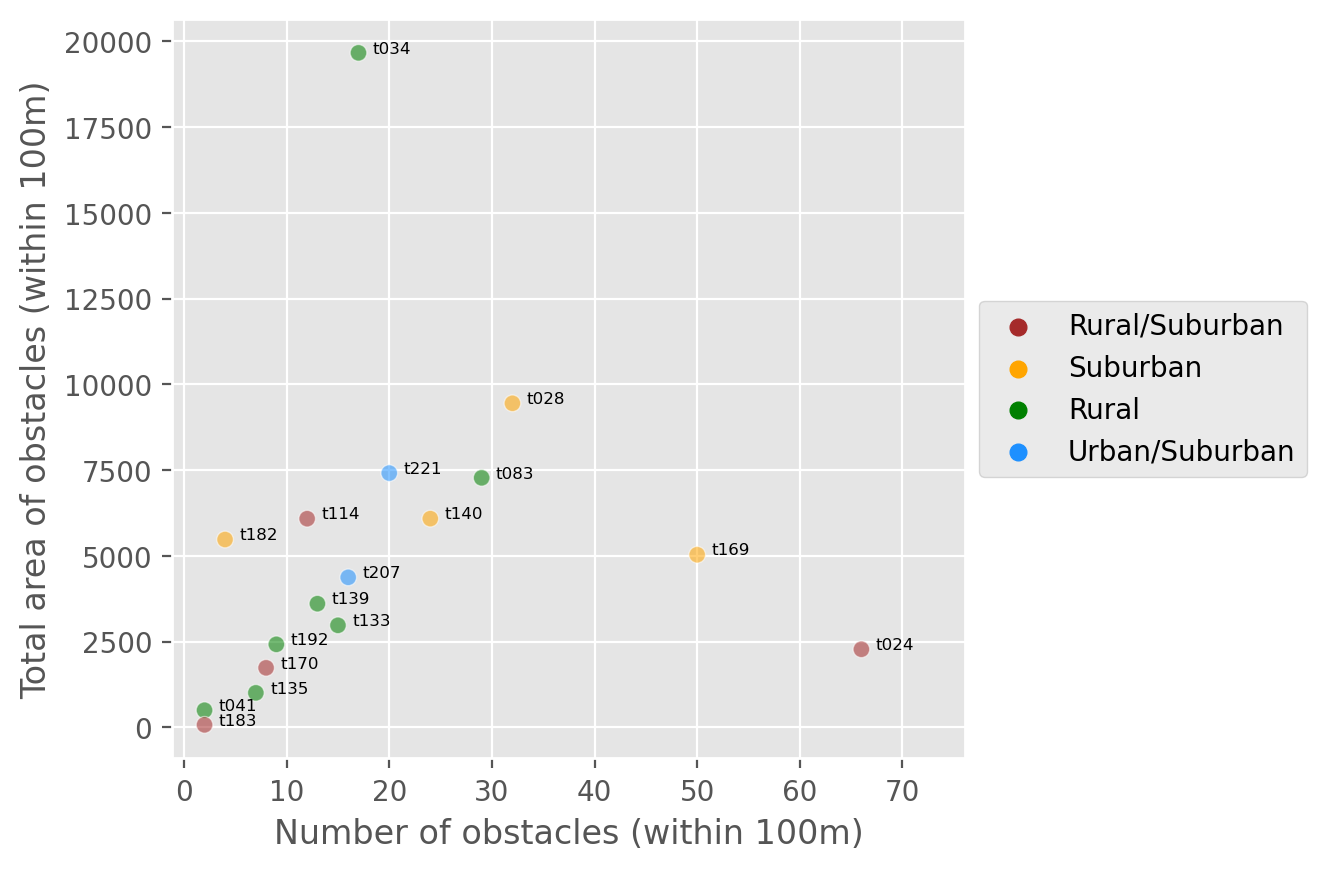

In [8]:
plt.style.use('ggplot')

sns.scatterplot(data=obstacle_specs, \
                x="Number of obstacles (within 100m)", \
                y="Total area of obstacles (within 100m)",\
                hue="Site Type",
                alpha=0.55,
                palette=['brown', 'orange', 'green','dodgerblue']
               );

def label_points(x, y, val, ax):
    xlim = ax.get_xlim()[1]
    offset = xlim / 50  # express offest as a fraction of width
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val']), fontsize=6.0)
# Increase x axis limit to help include the label for the rightmost point
ax = plt.gca()
label_points(obstacle_specs["Number of obstacles (within 100m)"], \
            obstacle_specs["Total area of obstacles (within 100m)"], \
            obstacle_specs.tid, \
            ax)  
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1] * 1.10);

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()